In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

# For 
from sklearn.preprocessing import LabelEncoder

# For baseline SVD algorithm
from scipy.sparse import csr_matrix, coo_matrix
from scipy.sparse.linalg import eigsh
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

import os, math, random, gc, time, pickle
from collections import Counter, defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from scipy import sparse

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, normalize
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Ridge

# from surprise import SVD, SVDpp, Dataset, Reader, accuracy


In [2]:
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

DATA_DIR = "data"
Z_THRESHOLD = 0.0   # z-score >= 0 => user "thích" phim
RATING_MIN, RATING_MAX = 0.5, 5.0
TEST_SIZE, VAL_SIZE = 0.10, 0.10
N_FEATURES_FS = 300 # Số lượng features sẽ lấy khi feature selection

USER_ID = 95133


# Load data

In [3]:
# Read file csv
ratings = pd.read_csv(f"{DATA_DIR}/ratings.csv")
movies = pd.read_csv(f"{DATA_DIR}/movies.csv")
tags = pd.read_csv(f"{DATA_DIR}/tags.csv")
genome_scores = pd.read_csv(f"{DATA_DIR}/genome-scores.csv")
genome_tags = pd.read_csv(f"{DATA_DIR}/genome-tags.csv")

# Merge để có title ngay trong ratings
df = pd.merge(ratings, movies, on='movieId')

In [5]:
print("THỐNG KÊ DỮ LIỆU")
total_movies  = movies["movieId"].nunique()          # tổng số phim trong bảng movies
rated_movies  = ratings["movieId"].nunique()         # phim đã có ít nhất 1 rating
tagged_movies = tags["movieId"].nunique()            # phim xuất hiện trong bảng tags

print(f"Original dataset : {len(df):,} ratings | "
      f"{df['userId'].nunique():,} users | "
      f"{df['movieId'].nunique():,} movies (after merge)")

print(f"Total movies      : {total_movies:,}")
print(f"Rated movies      : {rated_movies:,}")       
print(f"Movies in tags    : {tagged_movies:,}")
display(df.head())

THỐNG KÊ DỮ LIỆU
Original dataset : 25,000,095 ratings | 162,541 users | 59,047 movies (after merge)
Total movies      : 62,423
Rated movies      : 59,047
Movies in tags    : 45,251


,userId,movieId,rating,timestamp,title,genres
0,1,296,5.0,1147880044,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
1,1,306,3.5,1147868817,Three Colors: Red (Trois couleurs: Rouge) (1994),Drama
2,1,307,5.0,1147868828,Three Colors: Blue (Trois couleurs: Bleu) (1993),Drama
3,1,665,5.0,1147878820,Underground (1995),Comedy|Drama|War
4,1,899,3.5,1147868510,Singin' in the Rain (1952),Comedy|Musical|Romance


# Phân tích khám phá dữ liệu (EDA)

**Biểu đồ tần suất theo điểm đánh giá**

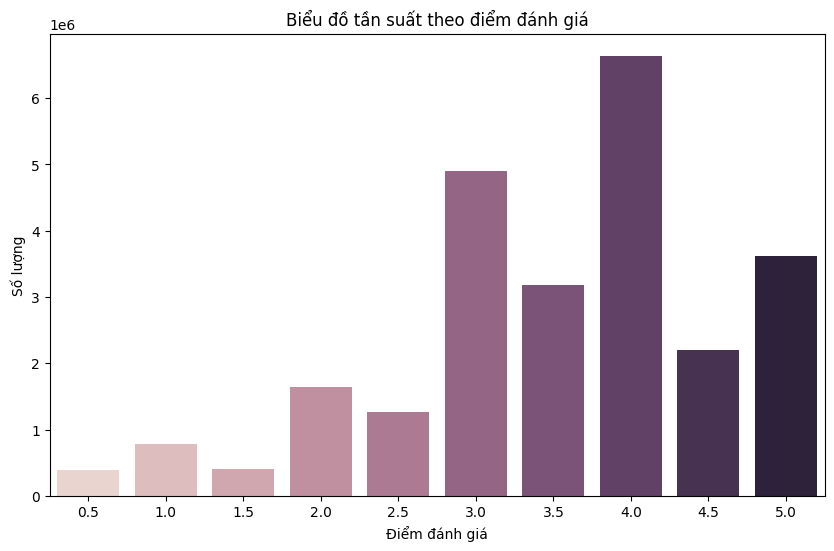

In [ ]:
# Vẽ biểu đồ 
plt.figure(figsize=(10, 6))
sns.countplot(data=ratings, x='rating', hue='rating', legend=False)
plt.title('Biểu đồ tần suất theo điểm đánh giá')
plt.xlabel('Điểm đánh giá')
plt.ylabel('Số lượng')
plt.show()

**Nhận xét:**
- Phần lớn các đánh giá tập trung ở mức cao, từ 3.0 đến 5.0.
- Rating 4.0 là phổ biến nhất, rating 3.0 đứng thứ hai về tần suất, rating 5.0 có số lượng đáng kể.
- Các ratings thấp (0.5, 1.0, 1.5) có tần suất thấp nhất.

***Kết luận:*** Dữ liệu cho thấy xu hướng đánh giá tích cực, với phần lớn người dùng hài lòng (ratings từ 3.5 trở lên). Các đánh giá tiêu cực (dưới 2.5) chiếm một tỷ lệ rất nhỏ.

## Phân tích theo phim

**Top 20 bộ phim có số lượt đánh giá nhiều nhất**

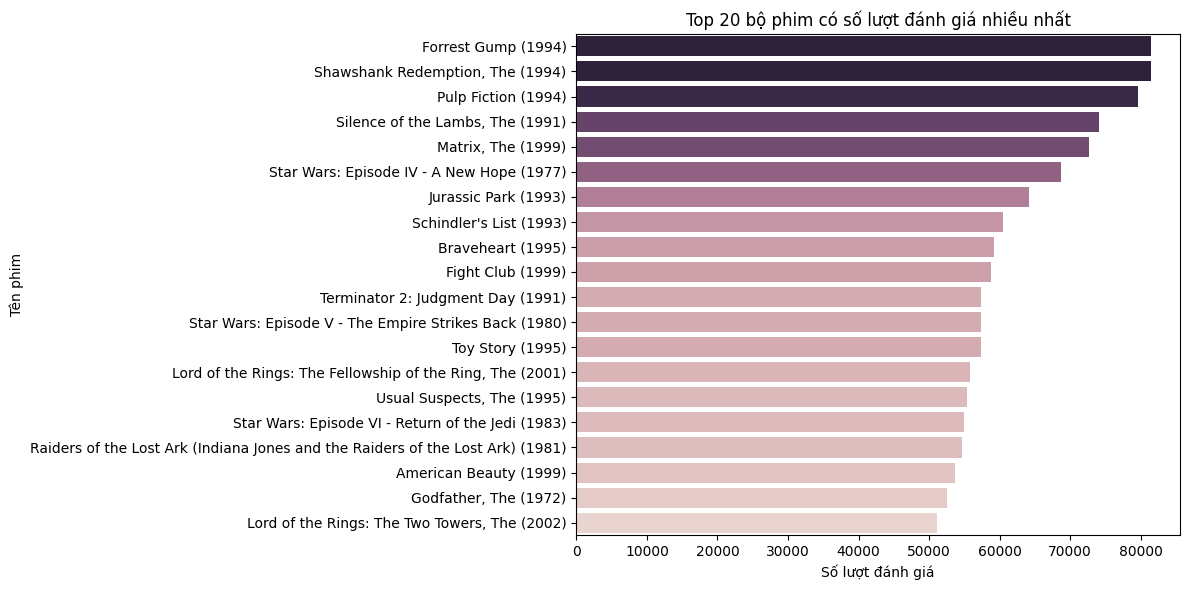

In [ ]:
# Lấy danh sách 20 bộ phim có số lượt đánh giá nhiều nhất
top_movies = ratings['movieId'].value_counts().head(20)
# Tạo DataFrame 
top_movies = pd.DataFrame({'movieId': top_movies.index, 'num_ratings': top_movies.values})
# Gộp dữ liệu với bảng 'movies' để lấy tên phim
top_movies = top_movies.merge(movies[['movieId', 'title']], on='movieId')

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
sns.barplot(y='title', x='num_ratings', hue='num_ratings', data=top_movies, legend=False)
plt.title('Top 20 bộ phim có số lượt đánh giá nhiều nhất')
plt.xlabel('Số lượt đánh giá')
plt.ylabel('Tên phim')
plt.tight_layout()
plt.show()

**Nhận xét:**
- Đa số các phim có lượt đánh giá cao là phim thập niên 90, phản ánh độ phổ biến của chúng trong bộ dữ liệu.
- Biểu đồ cho thấy các phim top đầu có lượt đánh giá nhiều hơn đáng kể với các bộ phim còn lại.

**Top 20 bộ phim có điểm trung bình cao nhất**

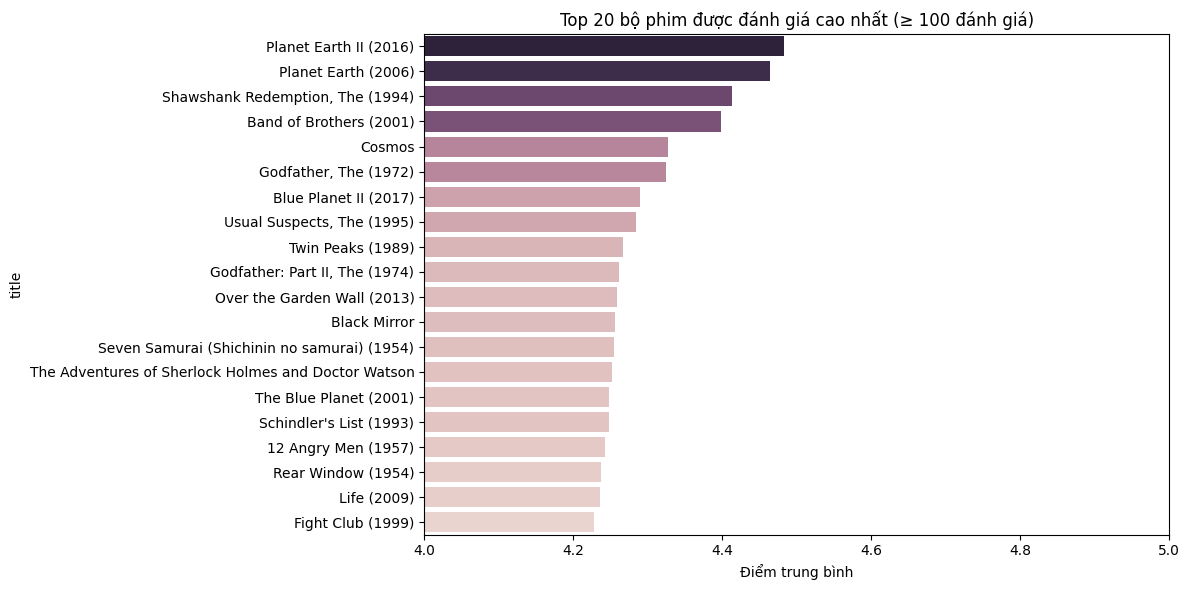

In [ ]:
# Tính điểm trung bình và số lượt đánh giá cho từng phim
movie_stats = ratings.groupby('movieId').agg(
    avg_rating=('rating', 'mean'),
    rating_count=('rating', 'count')
).reset_index()

# Lọc các bộ phim có ít nhất 100 đánh giá
popular_movies = movie_stats[movie_stats['rating_count'] >= 100]
# Lấy 20 bộ phim có điểm trung bình cao nhất
top_rated = popular_movies.sort_values(by='avg_rating', ascending=False).head(20)
# Gộp với bảng 'movies' để lấy title của phim
top_rated = top_rated.merge(movies[['movieId', 'title']], on='movieId')

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
sns.barplot(x='avg_rating', y='title', hue='avg_rating', data=top_rated, legend=False)
plt.title('Top 20 bộ phim được đánh giá cao nhất (≥ 100 đánh giá)')
plt.xlabel('Điểm trung bình')
plt.xlim(4, 5)
plt.tight_layout()
plt.show()

**Nhận xét:**
- Thời gian phát hành không là yếu tố quyết định chất lượng phim (thời kì nào cũng có phim chất lượng cao).
- Một số bộ phim xuất hiện trong cả hai danh sách (Shawshank Redemption, Godfather, Fight Club), chứng tỏ chúng vừa phổ biến vừa có chất lượng.

***Kết luận:*** Biểu đồ cho thấy sự đa dạng về thể loại và thời kỳ.

## Phân tích theo thể loại

**Biểu đồ phân phối của thể loại phim**

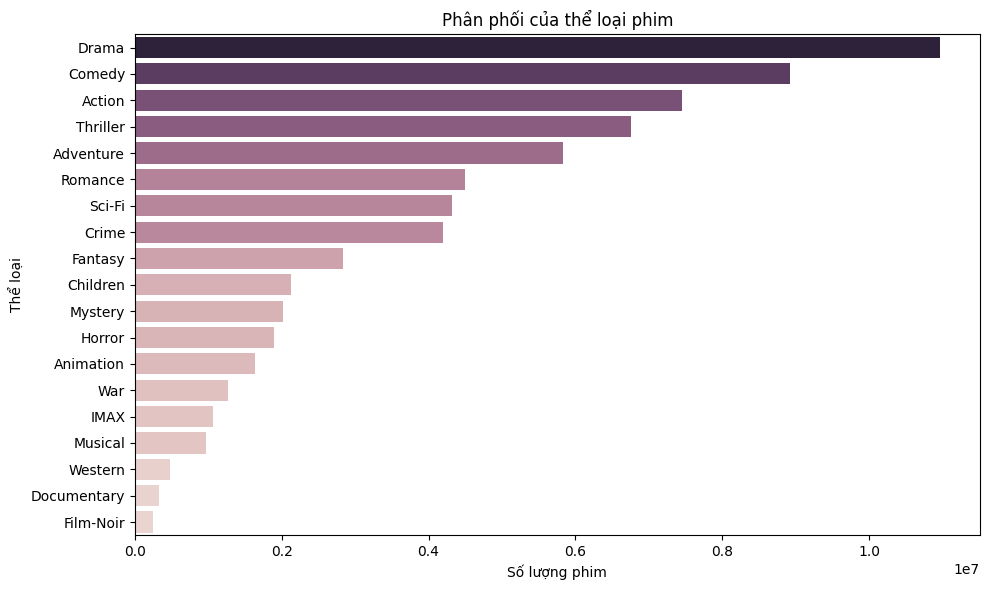

In [ ]:
# Thống kê số lượng các genres
merged = ratings.merge(movies, on='movieId')
merged = merged[merged['genres'] != '(no genres listed)']
merged['genres'] = merged['genres'].str.split('|')
exploded = merged.explode('genres')

# Đếm số lượng phim theo từng thể loại
genre_counts = exploded['genres'].value_counts().reset_index()
genre_counts.columns = ['genre', 'count']

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
sns.barplot(data=genre_counts, x='count', y='genre', hue='count', legend=False)
plt.title('Phân phối của thể loại phim')
plt.xlabel('Số lượng phim')
plt.ylabel('Thể loại')
plt.tight_layout()
plt.show()

**Nhận xét:**

- Biểu đồ thể hiện 19 thể loại phim, cho thấy dữ liệu có độ bao phủ thể loại khá rộng.

- Phân phối thể loại không đồng đều, tập trung vào các thể loại phổ biến nhiều như Drama, Comedy và Action. Ngược lại, các thể loại ít xuất hiện hơn thường là những loại ít được khai thác.

## Phân tích theo thời gian

**Biểu đồ cho thấy số lượng đánh giá theo năm**

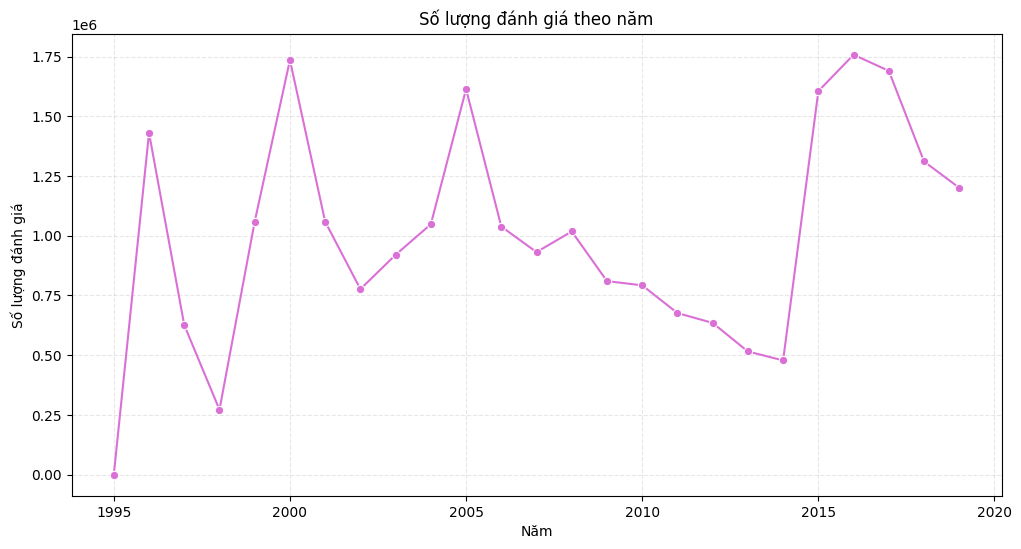

In [6]:
# Chuyển cột 'timestamp' sang kiểu datetime và lấy năm
ratings['year'] = pd.to_datetime(ratings['timestamp'], unit='s').dt.year
# Đếm số đánh giá theo từng năm
ratings_by_year = ratings['year'].value_counts().sort_index()

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
sns.lineplot(x=ratings_by_year.index, y=ratings_by_year.values, marker='o', color='orchid')
plt.title('Số lượng đánh giá theo năm')
plt.xlabel('Năm')
plt.ylabel('Số lượng đánh giá')
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

**Nhận xét:**

- Số lượng đánh giá biến động mạnh qua các năm, không theo xu hướng tuyến tính rõ ràng.

- Giai đoạn tương tác cao đột biến thể hiện rõ ràng ở 2 đỉnh vào năm 2000 và năm 2016. Giai đoạn 2010–2014 cho thấy mức sụt giảm kéo dài và chạm đáy. Sau 2015 thì dữ liệu phục hồi mạnh.

**Kết luận:** Phân phối đánh giá của người dùng theo thời gian là không ổn định.


**Biểu đồ heatmap: số lượt đánh giá theo năm và tháng**

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


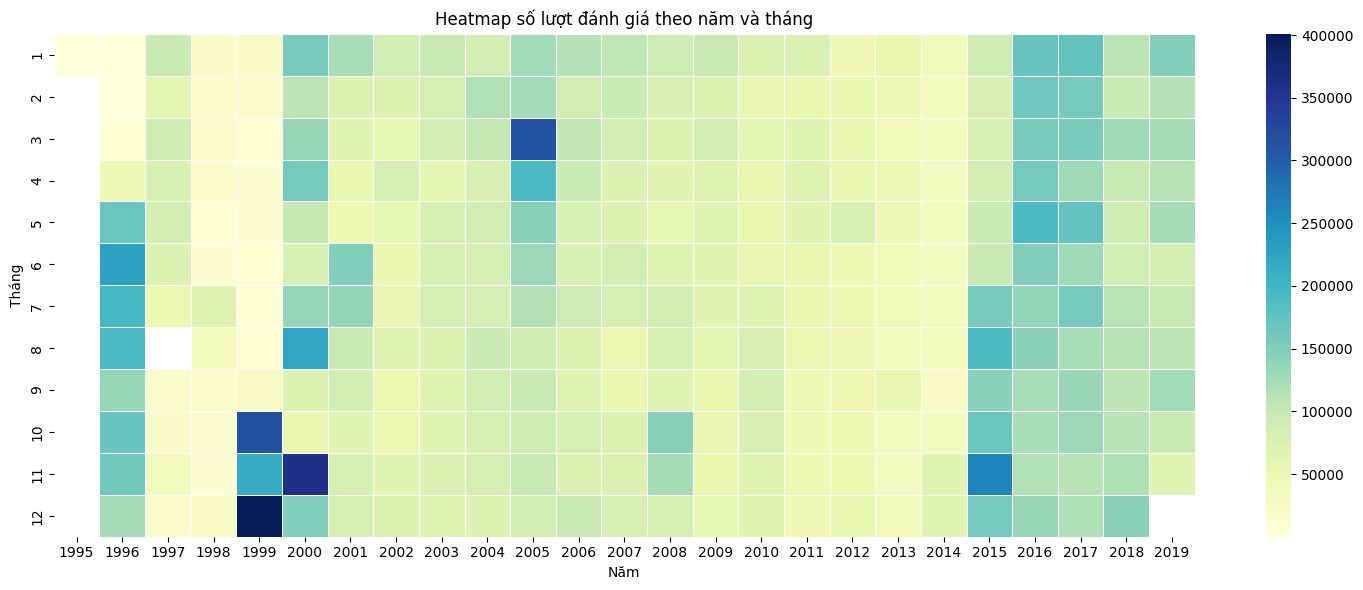

In [ ]:
# Chuyển cột 'timestamp' sang kiểu datetime và lấy theo tháng (Year-Month)
ratings['year_month'] = pd.to_datetime(ratings['timestamp'], unit='s').dt.to_period('M')
# Đếm số lượt đánh giá theo tháng và năm
ratings_heatmap = ratings.groupby(ratings['year_month']).size().reset_index(name='count')
ratings_heatmap['year'] = ratings_heatmap['year_month'].dt.year
ratings_heatmap['month'] = ratings_heatmap['year_month'].dt.month

# Tạo bảng pivot với tháng là index và năm là cột
pivot_table = ratings_heatmap.pivot(index='month', columns='year', values='count')

# Vẽ biểu đồ
plt.figure(figsize=(15, 6))
sns.heatmap(pivot_table, cmap='YlGnBu', linewidths=0.5, annot=False)
plt.title('Heatmap số lượt đánh giá theo năm và tháng')
plt.xlabel('Năm')
plt.ylabel('Tháng')
plt.tight_layout()
plt.show()

**Nhận xét:**

- Lượt đánh giá phân bố không đồng đều theo tháng và năm, thể hiện tính thời điểm rõ rệt.

- Một số "hotspot" nổi bật: cuối năm 1999, đầu 2005, và cuối 2015 — cho thấy các đợt tương tác bùng nổ ngắn hạn. 

- Giai đoạn 2010–2014 nhìn chung khá "lặng sóng", màu nhạt đồng đều – phản ánh mức độ tương tác thấp kéo dài.

**Kết luận:** Heatmap giúp phát hiện và quan sát rõ ràng hơn các giai đoạn đột biến số lượt đánh giá của người dùng.

# Pre-processing & Preparation

In [4]:
# Kiểm tra ratings hợp lệ (0.5 đến 5.0)
if (ratings['rating'] < 0.5).any() or (ratings['rating'] > 5.0).any():
    print("Warning: Invalid rating values detected.")

In [5]:
# Tính số lượng người dùng, phim và tổng số lượt đánh giá
n_users = ratings['userId'].nunique()
n_movies = ratings['movieId'].nunique()
n_ratings = len(ratings)

# Tính độ thưa (sparsity) của ma trận ratings
sparsity = 1 - n_ratings / (n_users * n_movies)
print(f"\nĐộ thưa của ma trận: {sparsity:.4f} ({n_ratings} ratings / {n_users * n_movies} possible ratings)")


Độ thưa của ma trận: 0.9974 (25000095 ratings / 9597558427 possible ratings)


## Mã hóa

In [6]:
# Encode userId và movieId thành chỉ số liên tục từ 0 để cho indexing ma trận
user_encoder = LabelEncoder()
user_encoder.fit(df['userId'])
df['user_idx'] = user_encoder.transform(df['userId'])

movie_encoder = LabelEncoder()
movie_encoder.fit(df['movieId'])
df['movie_idx'] = movie_encoder.transform(df['movieId'])

n_users  = df["user_idx"].nunique()
n_items  = df["movie_idx"].nunique()

## Chia dữ liệu để huấn luyện và kiểm tra

In [7]:
print("Splitting train/val/test...")
def train_val_test_split_func(data_frame, test_size=TEST_SIZE, val_size=VAL_SIZE, col="user_idx", seed=SEED):
    train_val, test = train_test_split(
        data_frame, 
        test_size=test_size, 
        random_state=seed, 
        stratify=data_frame[col]
    )
    train, val = train_test_split(
        train_val, 
        test_size=val_size, 
        random_state=seed, 
        stratify=train_val[col]
    )
    return train.reset_index(drop=True), val.reset_index(drop=True), test.reset_index(drop=True)

train_df, val_df, test_df = train_val_test_split_func(df)
print("Split sizes:", {k: len(v) for k, v in zip(["train", "val", "test"], [train_df, val_df, test_df])})

Splitting train/val/test...
Split sizes: {'train': 20250076, 'val': 2250009, 'test': 2500010}


# Thuật toán Truncated SVD

## 1. Cài đặt thuật toán

In [ ]:
def truncated_svd(X, n_components=30):
    """
    Tính Truncated SVD (Singular Value Decomposition) cho ma trận thưa X.

    Tham số:
        X: Ma trận thưa (users x movies)
        n_components: Số lượng thành phần chính (rank giảm chiều)
    
    Các bước thực hiện:
        1. Tính X.T @ X (movies x movies)
        2. Phân tích eigen: lấy top k các trị riêng (eigenvalues) và vector riêng (eigenvectors) lớn nhất
        3. Tính các giá trị kỳ dị (singular values) bằng căn bậc hai của eigenvalues
        4. Tính ma trận U = X @ V / Sigma
        5. Dựng lại ma trận xấp xỉ: X ~ U * Sigma * V^T

    Trả về:
        - X_approx: Ma trận xấp xỉ gốc với rank thấp hơn
    """

    # Bước 1: X.T @ X
    C = X.T.dot(X)

    # Bước 2: Phân tích eigen (chỉ lấy top k)
    eigenvalues, eigenvectors = eigsh(C, k=n_components, which='LM')

    # Bước 3: Sắp xếp các trị riêng theo thứ tự giảm dần
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]

    # Bước 4: Tính singular values từ eigenvalues
    Sigma = np.sqrt(eigenvalues)

    # Bước 5: Tính ma trận U
    U = X.dot(eigenvectors)
    U = U / Sigma[np.newaxis, :]

    Vt = eigenvectors.T
    
    return U, Sigma, Vt  


def svd_baseline_predict(ratings_df, user_enc, movie_enc, k=50):
    """
    Dự đoán rating bằng phương pháp SVD có chuẩn hóa (phiên bản đơn giản của Iterative SVD) theo người dùng.

    Tham số:
        ratings_df: DataFrame chứa các cột ['user_idx', 'movie_idx', 'rating']
        user_enc, movie_enc: LabelEncoder đã fit
        k: Số lượng thành phần ẩn (rank giảm chiều)
        
    Các bước thực hiện:
        1. Khởi tạo ma trận rating rời rạc từ dữ liệu.
        2. Tính trung bình ratings theo từng hàng (user).
        3. Mean-center ma trận bằng cách trừ trung bình từng user.
        4. Áp dụng Truncated SVD để xấp xỉ ma trận chuẩn hóa.
        5. Cộng lại trung bình user để khôi phục thang điểm ban đầu.

    Trả về:
        R_hat: Ma trận dự đoán (users x movies)
        R: Ma trận gốc ở dạng sparse
        row_means: Giá trị trung bình ratings theo từng user
    """

    # Kiểm tra tính hợp lệ của dữ liệu đầu vào
    required_columns = ['user_idx', 'movie_idx', 'rating']
    if not all(col in ratings_df.columns for col in required_columns):
        raise ValueError(f"ratings_df must contain columns: {required_columns}")
    if ratings_df[required_columns].isnull().any().any():
        raise ValueError("ratings_df contains NaN values.")

    ratings_df = ratings_df.copy()

    n_users = len(user_enc.classes_)
    n_movies = len(movie_enc.classes_)

    if k > min(n_users, n_movies):
        raise ValueError(f"k={k} is too large. Must be <= {min(n_users, n_movies)}")

    # Bước 1: Tạo sparse matrix từ ratings gốc
    row = ratings_df['user_idx'].values
    col = ratings_df['movie_idx'].values
    data = ratings_df['rating'].values
    R = coo_matrix((data, (row, col)), shape=(n_users, n_movies))

    #  Bước 2: Tính trung bình ratings theo từng user (row_means)
    row_sums = np.array(R.sum(axis=1)).flatten()
    row_counts = np.array((R != 0).sum(axis=1)).flatten()
    row_means = np.zeros(n_users)
    mask = row_counts > 0
    row_means[mask] = row_sums[mask] / row_counts[mask]

    # Bước 3: Chuẩn hóa ma trận bằng cách trừ trung bình mỗi user (Mean-center)
    R_centered = R.copy()
    R_centered.data -= row_means[R_centered.row]

    # Bước 4: Áp dụng Truncated SVD lên ma trận chuẩn hóa
    U, S, Vt = truncated_svd(R_centered, n_components=k)

    # Bước 5: Khôi phục lại ma trận dự đoán ban đầu
    R_hat_centered = U @ np.diag(S) @ Vt
    R_hat = R_hat_centered + row_means[:, np.newaxis]

    return R_hat, R, row_means

def predict_ratings(df, X_approx):
    """
    Dự đoán ratings từ ma trận xấp xỉ
    Sử dụng NumPy arrays để tối ưu tốc độ
    """
    user_indices = df['user_idx'].values
    movie_indices = df['movie_idx'].values
    
    # Tạo mask cho các chỉ số hợp lệ
    valid_mask = (user_indices < X_approx.shape[0]) & (movie_indices < X_approx.shape[1])
    
    # Chỉ lấy những chỉ số hợp lệ
    valid_users = user_indices[valid_mask]
    valid_movies = movie_indices[valid_mask]
    
    # Dự đoán vectorized
    predictions = X_approx[valid_users, valid_movies]
    
    return predictions

## 2. Áp dụng thuật toán

In [ ]:
# Tạo ma trận thưa từ tập train (users x movies)
train_matrix = csr_matrix((train_df['rating'], (train_df['user_idx'], train_df['movie_idx'])),
                          shape=(df['user_idx'].nunique(), df['movie_idx'].nunique()))

# Áp dụng Truncated SVD để giảm chiều
U, Sigma, Vt = truncated_svd(train_matrix, n_components=30)  # Nhận tuple
X_approx = U @ np.diag(Sigma) @ Vt  # Tính ma trận xấp xỉ từ tuple

## 3. Đánh giá

In [ ]:
def evaluate_metric(df, X_approx):
    """
    Đánh giá độ chính xác của các giá trị ratings dự đoán so với giá trị thực tế.

    Tham số:
        df : Chứa các cột ['user_idx', 'movie_idx', 'rating']
        X_approx : Ma trận xấp xỉ

    Trả về:
        rmse : Root Mean Squared Error - Sai số bình phương trung bình
        mae  : Mean Absolute Error - Sai số tuyệt đối trung bình
    """
    actuals = df['rating'].tolist()
    predictions = predict_ratings(df, X_approx)
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    mae = mean_absolute_error(actuals, predictions)
    return rmse, mae

In [ ]:
#  svd_baseline_predict 
R_hat, R, row_means = svd_baseline_predict(train_df, user_encoder, movie_encoder, k=30)
train_rmse, train_mae = evaluate_metric(train_df, R_hat)
test_rmse, test_mae = evaluate_metric(test_df, R_hat)

print("SVD CÓ CHUẨN HOÁ")
print(f"Train RMSE: {train_rmse:.4f} | MAE: {train_mae:.4f}")
print(f"Test  RMSE: {test_rmse:.4f} | MAE: {test_mae:.4f}")

SVD CÓ CHUẨN HOÁ
Train RMSE: 0.8540 | MAE: 0.6428
Test  RMSE: 0.8931 | MAE: 0.6819


## 4. Gợi ý phim

In [ ]:
def recommend_movies(user_id, X_approx, user_encoder, movie_encoder, movies_df, ratings_df, top_n=10):
    '''
    Gợi ý top_n phim cho user_id dựa trên SVD, loại bỏ những phim đã xem
    '''
    if user_id not in user_encoder.classes_:
        return pd.DataFrame()
    
    user_idx = user_encoder.transform([user_id])[0]
    watched_movies = set(ratings_df[ratings_df['userId'] == user_id]['movieId'])
    scores = X_approx[user_idx]
    
    # Lấy top phim chưa xem
    recommendations = []
    for movie_idx in np.argsort(scores)[::-1]:
        movie_id = movie_encoder.inverse_transform([movie_idx])[0]
        if movie_id not in watched_movies:
            recommendations.append({'movieId': movie_id, 'predicted_rating': scores[movie_idx]})
            if len(recommendations) >= top_n:
                break
    
    if not recommendations:
        return pd.DataFrame()
    
    return pd.DataFrame(recommendations).merge(
        movies_df[['movieId', 'title', 'genres']], on='movieId', how='left'
    )[['movieId', 'title', 'genres', 'predicted_rating']]

# HIỂN THỊ POSTER MOVIES 
# TMDB API setup
TMDB_API_KEY = "2307c3e2979636e48540fc3c2c7dbaec"

# Lấy đường dẫn poster từ TMDB API bằng tmdb_id.
def fetch_poster(tmdb_id, api_key):
    if pd.isna(tmdb_id):
        return None
    url = f"https://api.themoviedb.org/3/movie/{int(tmdb_id)}?api_key={api_key}"
    try:
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json()
            poster_path = data.get("poster_path")
            if poster_path:
                return f"https://image.tmdb.org/t/p/w200{poster_path}"
    except:
        pass
    return None

# Thêm cột 'poster_url' vào DataFrame dựa trên movieId và links.csv.
def add_poster_column(df, links_df, api_key):
    df = df.merge(links_df[['movieId', 'tmdbId']], on='movieId', how='left')
    df['poster_url'] = df['tmdbId'].apply(lambda x: fetch_poster(x, api_key))
    return df.drop(columns=['tmdbId'])

# Hiển thị poster
def display_with_posters(df):
    html = "<table><tr><th>Movie ID</th><th>Title</th><th>Genres</th><th>Predicted Rating</th><th>Poster</th></tr>"
    for _, row in df.iterrows():
        poster_img = (
            f"<img src='{row['poster_url']}' width='200' height='280'>" 
            if row['poster_url'] else "N/A"
        )
        html += (
            f"<tr>"
            f"<td>{row['movieId']}</td>"
            f"<td>{row['title']}</td>"
            f"<td>{row['genres']}</td>"
            f"<td>{row['predicted_rating']:.2f}</td>"
            f"<td>{poster_img}</td>"
            f"</tr>"
        )
    html += "</table>"
    return HTML(html)

In [ ]:
# Gợi ý phim cho người dùng được chọn
links = pd.read_csv(f"{DATA_DIR}/links.csv")
print(f"Gợi ý cho người dùng: {USER_ID}")
recommendations = recommend_movies(USER_ID, R_hat, user_encoder, movie_encoder, movies, ratings)

predict = add_poster_column(recommendations, links, TMDB_API_KEY)
display_with_posters(predict)

Gợi ý cho người dùng: 95133


Movie ID,Title,Genres,Predicted Rating,Poster
109487,Interstellar (2014),Sci-Fi|IMAX,4.25,
2329,American History X (1998),Crime|Drama,3.85,
164179,Arrival (2016),Sci-Fi,3.84,
68237,Moon (2009),Drama|Mystery|Sci-Fi|Thriller,3.73,
92259,Intouchables (2011),Comedy|Drama,3.66,
6874,Kill Bill: Vol. 1 (2003),Action|Crime|Thriller,3.54,
44555,"Lives of Others, The (Das leben der Anderen) (2006)",Drama|Romance|Thriller,3.50,
7438,Kill Bill: Vol. 2 (2004),Action|Drama|Thriller,3.44,
1617,L.A. Confidential (1997),Crime|Film-Noir|Mystery|Thriller,3.42,
2542,"Lock, Stock & Two Smoking Barrels (1998)",Comedy|Crime|Thriller,3.41,


# Các thuật toán advanced SVD

## **Thuật toán FunkSVD**

### ***1. Thuật toán***

- **Mục tiêu:** Xấp xỉ ma trận đánh giá thưa $$ R \in \mathbb{R}^{n_{\text{users}} \times n_{\text{items}}} $$ bằng tích của hai ma trận yếu tố ẩn  
  $$ P \in \mathbb{R}^{n_{\text{users}} \times k}, \quad Q \in \mathbb{R}^{n_{\text{items}} \times k}, \quad R \approx PQ^T $$

- **Dự đoán:** Điểm đánh giá dự đoán cho người dùng $ u $ và phim $ i $:

  $$
  \hat{r}_{ui} = \mu + b_u + b_i + P_u \cdot Q_i
  $$

  Trong đó:

  - $\mu $: Trung bình toàn bộ đánh giá (global bias).
  - $ b_u $: Bias của người dùng $u$ (xu hướng đánh giá cao/thấp).
  - $ b_i $: Bias của phim $ i $ (xu hướng được đánh giá cao/thấp).
  - $ P_u \cdot Q_i $: Tích vô hướng của vector yếu tố ẩn (kích thước $ k $).

- **Hàm mất mát:** Tối thiểu hóa sai số bình phương với điều chuẩn riêng cho bias và yếu tố ẩn:

  $
  L = \sum_{(u,i) \in \text{known ratings}} (r_{ui} - \hat{r}_{ui})^2 + \lambda_{bu,bi} \left( \sum_u b_u^2 + \sum_i b_i^2 \right) + \lambda_{pq} \left( \sum_u \| P_u \|^2 + \sum_i \| Q_i \|^2 \right)
  $

  Trong đó:

  - $ (r_{ui} - \hat{r}_{ui})^2 $: Sai số bình phương.
  - $ \lambda_{bu,bi} $: Hệ số điều chuẩn cho bias (`reg_bu_bi`).
  - $ \lambda_{pq} $: Hệ số điều chuẩn cho yếu tố ẩn (`reg_pq`).
  - $ b_u^2, b_i^2, \|P_u\|^2, \|Q_i\|^2 $: Phạt các giá trị lớn để tránh overfitting.

- **Tối ưu hóa:** Sử dụng SGD để cập nhật $ \mu, b_u, b_i, P_u, Q_i $ từng mẫu dữ liệu một cách ngẫu nhiên, với learning rate giảm dần (decay).


### ***2. Xây dựng model bằng hai cách***

#### *Cách 1. Sử dụng mô hình implement*

In [ ]:
# Hàm df_to_numpy() dùng để chuyển DataFrame sang NumPy
def df_to_numpy(df_):
    arr = df_[["user_idx", "movie_idx", "rating"]].to_numpy()
    return arr[:, 0].astype(np.int32), arr[:, 1].astype(np.int32), arr[:, 2].astype(np.float32)

In [ ]:
class FunkSVD:
    def __init__(
        self,
        n_users: int,               # số người dùng
        n_items: int,               # số phim
        k: int = 50,                # yếu tố ẩn
        lr: float = 0.007,
        reg_bu_bi: float = 0.01,    # Hệ số điều chuẩn cho bias (b_u, b_i).
        reg_pq: float = 0.05,       # Hệ số điều chuẩn cho yếu tố ẩn (P, Q ).
        n_epochs: int = 35,
        seed: int = 42,
        verbose: bool = True,
    ):
        rng = np.random.default_rng(seed)
        # Ma trận yếu tố ẩn người dùng, khởi tạo ngẫu nhiên từ phân phối chuẩn, nhân 0.1 để giá trị nhỏ, kiểu float32.
        self.P  = 0.1 * rng.standard_normal((n_users, k)).astype(np.float32)
        # Ma trận yếu tố ẩn phim
        self.Q  = 0.1 * rng.standard_normal((n_items, k)).astype(np.float32)
        #---> Khởi tạo ngẫu nhiên P, Q với giá trị nhỏ tránh gradient lớn ban đầu.
        
        # Vector bias người dùng (b_u) -> khởi tạo = 0
        self.bu = np.zeros(n_users, dtype=np.float32)
        # Vector bias phim (b_i), khởi tạo = 0
        self.bi = np.zeros(n_items, dtype=np.float32)
        #  Global bias (\mu), khởi tạo = 0 
        self.mu = 0.0

        self.lr0 = self.lr = lr # Lưu tốc độ học ban đầu và hiện tại (sẽ giảm qua epoch)
        self.reg_bu_bi = reg_bu_bi
        self.reg_pq    = reg_pq
        self.n_epochs  = n_epochs
        self.verbose   = verbose
        self.train_rmse, self.val_rmse = [], []

    # ───── Train ─────
    def fit(self, train_df, val_df=None, patience: int = 3):
        u_tr, i_tr, r_tr = df_to_numpy(train_df)
        if val_df is not None:
            u_vl, i_vl, r_vl = df_to_numpy(val_df)

        self.mu = r_tr.mean()
        best_val = np.inf
        no_improve = 0

        for ep in range(1, self.n_epochs + 1):
            idx = np.random.permutation(len(r_tr))
            se = 0.0
            for u, i, r in zip(u_tr[idx], i_tr[idx], r_tr[idx]):
                pred = self.mu + self.bu[u] + self.bi[i] + self.P[u] @ self.Q[i]
                err  = r - pred
                se  += err * err

                # update bias
                self.bu[u] += self.lr * (err - self.reg_bu_bi * self.bu[u])
                self.bi[i] += self.lr * (err - self.reg_bu_bi * self.bi[i])

                # update latent factors
                pu_old = self.P[u].copy()
                self.P[u] += self.lr * (err * self.Q[i] - self.reg_pq * self.P[u])
                self.Q[i] += self.lr * (err * pu_old    - self.reg_pq * self.Q[i])

            rmse_tr = np.sqrt(se / len(r_tr))
            self.train_rmse.append(rmse_tr)

            # Validation
            if val_df is not None:
                preds = self.predict_batch(u_vl, i_vl)
                rmse_vl = np.sqrt(mean_squared_error(r_vl, preds))
                self.val_rmse.append(rmse_vl)

                if self.verbose:
                    print(f"Epoch {ep:02d}/{self.n_epochs} – Train {rmse_tr:.4f} | Val {rmse_vl:.4f}")

                # early-stopping
                if rmse_vl + 1e-4 < best_val:
                    best_val = rmse_vl
                    no_improve = 0
                    self._best_state = (self.P.copy(), self.Q.copy(), self.bu.copy(), self.bi.copy())
                else:
                    no_improve += 1
                    if no_improve >= patience:
                        if self.verbose:
                            print(">>> Early-stopping – restore best epoch.")
                        self.P, self.Q, self.bu, self.bi = self._best_state
                        break
            else:
                if self.verbose:
                    print(f"Epoch {ep:02d}/{self.n_epochs} – Train RMSE: {rmse_tr:.4f}")

            self.lr *= 0.95

        return self

    # ───── Inference ─────
    def predict(self, u_idx: int, i_idx: int) -> float:
        est = (
            self.mu
            + self.bu[u_idx]
            + self.bi[i_idx]                
            + self.P[u_idx] @ self.Q[i_idx]
        )
        return float(np.clip(est, 0.5, 5.0))

    def predict_batch(self, users, items):
        return np.clip(
            self.mu + self.bu[users] + self.bi[items] +
            np.einsum("ij,ij->i", self.P[users], self.Q[items]),
            0.5, 5.0,
        )

    # ───── Save / Load ─────
    def save(self, file_path: str):
        """
        Lưu mô hình ra file .npz. 
        """
        dir_name = os.path.dirname(file_path)
        if dir_name and not os.path.exists(dir_name):
            os.makedirs(dir_name, exist_ok=True)

        np.savez_compressed(
            file_path,
            P=self.P, Q=self.Q,
            bu=self.bu, bi=self.bi,
            mu=self.mu,
            train_rmse=np.array(self.train_rmse),
            val_rmse=np.array(self.val_rmse),
            lr=self.lr, lr0=self.lr0,
            reg_bu_bi=self.reg_bu_bi,
            reg_pq=self.reg_pq,
        )

    def load(self, file_path: str):
        """
        Khôi phục model từ file .npz.
        """
        data = np.load(file_path)
        self.P  = data["P"];  self.Q  = data["Q"]
        self.bu = data["bu"]; self.bi = data["bi"]
        self.mu = float(data["mu"])
        self.train_rmse = list(data["train_rmse"])
        self.val_rmse   = list(data["val_rmse"])
        self.lr  = float(data["lr"]);  self.lr0 = float(data["lr0"])
        self.reg_bu_bi = float(data["reg_bu_bi"])
        self.reg_pq    = float(data["reg_pq"])
        return self

In [ ]:
model_funksvd_custom = FunkSVD(
    n_users=n_users,
    n_items=n_items,
    k=50,
    lr=0.007,
    reg_bu_bi=0.01,
    reg_pq=0.05,
    n_epochs=35,
)
model_funksvd_custom.fit(train_df, val_df, patience=3)
model_funksvd_custom.save(f"{DATA_DIR}/funksvd_best.npz")   

Epoch 01/35 – Train 0.9029 | Val 0.8770
Epoch 02/35 – Train 0.8686 | Val 0.8676
Epoch 03/35 – Train 0.8608 | Val 0.8630
Epoch 04/35 – Train 0.8548 | Val 0.8576
Epoch 05/35 – Train 0.8475 | Val 0.8511
Epoch 06/35 – Train 0.8403 | Val 0.8457
Epoch 07/35 – Train 0.8347 | Val 0.8419
Epoch 08/35 – Train 0.8300 | Val 0.8385
Epoch 09/35 – Train 0.8259 | Val 0.8353
Epoch 10/35 – Train 0.8219 | Val 0.8324
Epoch 11/35 – Train 0.8181 | Val 0.8297
Epoch 12/35 – Train 0.8144 | Val 0.8270
Epoch 13/35 – Train 0.8109 | Val 0.8244
Epoch 14/35 – Train 0.8075 | Val 0.8222
Epoch 15/35 – Train 0.8043 | Val 0.8201
Epoch 16/35 – Train 0.8014 | Val 0.8181
Epoch 17/35 – Train 0.7986 | Val 0.8163
Epoch 18/35 – Train 0.7960 | Val 0.8146
Epoch 19/35 – Train 0.7936 | Val 0.8131
Epoch 20/35 – Train 0.7913 | Val 0.8117
Epoch 21/35 – Train 0.7892 | Val 0.8104
Epoch 22/35 – Train 0.7872 | Val 0.8093
Epoch 23/35 – Train 0.7854 | Val 0.8082
Epoch 24/35 – Train 0.7837 | Val 0.8072
Epoch 25/35 – Train 0.7821 | Val 0.8063


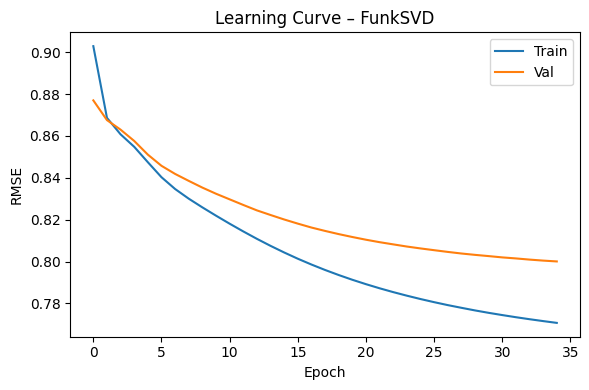

In [ ]:
# learning curve
plt.figure(figsize=(6, 4))
plt.plot(model_funksvd_custom.train_rmse, label="Train")
if model_funksvd_custom.val_rmse:
    plt.plot(model_funksvd_custom.val_rmse, label="Val")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Learning Curve – FunkSVD")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
def evaluate(df_, mdl):
    u, i, r = df_to_numpy(df_)
    pr = mdl.predict_batch(u, i)
    return np.sqrt(mean_squared_error(r, pr)), mean_absolute_error(r, pr)

train_rmse, train_mae = evaluate(train_df, model_funksvd_custom)
val_rmse, val_mae = evaluate(val_df, model_funksvd_custom)
test_rmse, test_mae = evaluate(test_df, model_funksvd_custom)

print(
    f"\nRMSE | MAE\n"
    f"Train: {train_rmse:.4f} | {train_mae:.4f}\n"
    f"Val  : {val_rmse:.4f} | {val_mae:.4f}\n"
    f"Test : {test_rmse:.4f} | {test_mae:.4f}"
)


RMSE | MAE
Train: 0.7691 | 0.5855
Val  : 0.8001 | 0.6073
Test : 0.8005 | 0.6076


#### *Cách 2. Sử dụng mô hình từ thư viện Surprise*

In [ ]:
class SurpriseFunkSVD:
    def __init__(
        self,
        n_factors=50,
        lr_all=0.007,
        reg_all=0.02,
        n_epochs=20,
        verbose=False,
        rating_scale=(0.5, 5.0)
    ):
        self.model = SVD(n_factors=n_factors, lr_all=lr_all, reg_all=reg_all,
                         n_epochs=n_epochs, verbose=verbose)
        self.rating_scale = rating_scale

    def fit(self, train_df):
        reader = Reader(rating_scale=self.rating_scale)
        data = Dataset.load_from_df(train_df[['user_idx', 'movie_idx', 'rating']], reader)
        trainset = data.build_full_trainset()
        self.model.fit(trainset)
        return self

    def predict(self, u_idx: int, i_idx: int) -> float:
        est = self.model.predict(uid=u_idx, iid=i_idx).est
        return float(np.clip(est, *self.rating_scale))

    def predict_batch(self, users, items):
        preds = []
        for u, i in tqdm(zip(users, items), total=len(users), desc="Predicting"):
            preds.append(self.predict(u, i))
        return np.array(preds)

    def recommend_for_nan(self, df):
        df_nan = df[df["rating"].isna()].copy()
        predictions = self.predict_batch(df_nan["user_idx"].values, df_nan["movie_idx"].values)
        df_nan["predicted_rating"] = predictions
        return df_nan

    def save(self, file_path: str):
        import joblib
        joblib.dump(self.model, file_path)

    def load(self, file_path: str):
        import joblib
        self.model = joblib.load(file_path)
        return self

In [ ]:
# Khởi tạo và train model SVD với thư viện surprise
model_funksvd = SurpriseFunkSVD(n_factors=50, n_epochs=35)
model_funksvd.fit(train_df) 

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29
Processing epoch 30
Processing epoch 31
Processing epoch 32
Processing epoch 33
Processing epoch 34


In [ ]:
# Lưu model ra file để dùng lại sau này (không cần train lại)
with open(f"{DATA_DIR}/model_funksvd.pkl", 'wb') as f:
    pickle.dump(model_funksvd, f)

In [ ]:
# Dự đoán rating trên tập val
preds = model_funksvd.predict_batch(val_df["user_idx"], val_df["movie_idx"])
val_df["predicted_rating"] = preds

Predicting: 100%|██████████| 2000008/2000008 [00:28<00:00, 70853.08it/s] 


In [ ]:
def evaluate(df, model):
    u, i, r = df["user_idx"], df["movie_idx"], df["rating"]
    p = model.predict_batch(u, i)
    return np.sqrt(mean_squared_error(r, p)), mean_absolute_error(r, p)

tr_rmse, tr_mae = evaluate(train_df, model_funksvd)
vl_rmse, vl_mae = evaluate(val_df, model_funksvd)
ts_rmse, ts_mae = evaluate(test_df, model_funksvd)

print(
    f"\nRMSE  | MAE\n"
    f"Train: {tr_rmse:.4f} | {tr_mae:.4f}\n"
    f"Val  : {vl_rmse:.4f} | {vl_mae:.4f}\n"
    f"Test : {ts_rmse:.4f} | {ts_mae:.4f}"
)


Predicting: 100%|██████████| 5000019/5000019 [01:18<00:00, 64042.52it/s] 



RMSE  | MAE
Train: 0.6132 | 0.4646
Val  : 0.7863 | 0.5916
Test : 0.7862 | 0.5916


## **Thuật toán SVD++**

### ***1. Thuật toán***

#### **a. Công thức dự đoán rating và ý tưởng**

Giả sử $R_{n \times m}$ là ma trận đánh giá gồm $n$ người dùng và $m$ mặt hàng. Mỗi phần tử $r_{ui}$ là đánh giá của người dùng $u$ cho mặt hàng $i$.

Công thức dự đoán rating trong mô hình **SVD++** là:

$$
\hat{r}_{ui} = \mu + b_u + b_i + q_i^T \left(p_u + \frac{1}{\sqrt{|N(u)|}} \sum_{j \in N(u)} y_j \right)
$$

Trong đó:

- $\mu$: trung bình các rating toàn bộ hệ thống  
- $b_u$, $b_i$: độ lệch riêng của người dùng $u$ và movie $i$  
- $p_u$, $q_i$: vector tiềm ẩn đại diện cho người dùng và movie
- $y_j$: vector phản hồi ngầm của movie $j$
- $N(u)$: tập các movie mà người dùng $u$ đã đánh giá

Ý tưởng của SVD++ là kết hợp **cả thông tin explicit (rating)** và **implicit feedback (dạng hành vi như gắn tag, click, xem phim, v.v.)** để cải thiện độ chính xác khi dự đoán.


#### **b. Hàm mất mát (Loss function)**

Hàm mất mát của mô hình SVD++ được định nghĩa như sau:

$$
\sum_{r_{ui} \in R} \left[ \left(r_{ui} - \mu - b_u - b_i - q_i^T \left(p_u + \frac{1}{\sqrt{|N(u)|}} \sum_{j \in R(u)} y_j \right) \right)^2 + \lambda_1 (b_u^2 + b_i^2) + \lambda_2 ( \|p_u\|^2 + \|q_i\|^2 ) \right]
$$

Giải thích các thành phần:

- Thành phần đầu là **sai số bình phương** giữa rating thực tế và rating dự đoán.

- Các biểu thức chứa $\lambda_1$ và $\lambda_2$ là **regularization**:

  - $\lambda_1$: điều chỉnh độ lệch (bias)

  - $\lambda_2$: điều chỉnh độ lớn của vector tiềm ẩn

Regularization giúp giảm **overfitting**, nhất là khi dữ liệu đánh giá bị **thưa** (sparse). Nó hạn chế mô hình "học thuộc" toàn bộ dữ liệu train và giúp tổng quát hóa tốt hơn trên tập validation.


#### **c. Quy tắc cập nhật tham số bằng SGD**

Với mỗi mini-batch, chọn ngẫu nhiên các mẫu và cập nhật các tham số $b_u, b_i, p_u, q_i, y_j$ dựa trên sai số $e_{ui} = r_{ui} - \hat{r}_{ui}$ theo các công thức sau:

- $
b_u \leftarrow b_u + \gamma \cdot (e_{ui} - \lambda_1 \cdot b_u)
$

- $
b_i \leftarrow b_i + \gamma \cdot (e_{ui} - \lambda_1 \cdot b_i)
$

- $
q_i \leftarrow q_i + \gamma \cdot \left( e_{ui} \cdot \left( p_u + \frac{1}{\sqrt{|N(u)|}} \sum_{j \in N(u)} y_j \right) - \lambda_2 \cdot q_i \right)
$

- $
p_u \leftarrow p_u + \gamma \cdot (e_{ui} \cdot q_i - \lambda_2 \cdot p_u)
$

- $
\forall j \in N(u): \quad y_j \leftarrow y_j + \gamma \cdot \left( \frac{e_{ui}}{\sqrt{|N(u)|}} \cdot q_i - \lambda_2 \cdot y_j \right)
$

Trong đó:

- $\gamma$: learning rate  
- $\lambda_1, \lambda_2$: hệ số regularization  
- $N(u)$: tập các movie mà user $u$ đã đánh giá  

Mỗi lần cập nhật là một bước tiến nhỏ giúp mô hình tối ưu dần các tham số để giảm sai số dự đoán.


### ***2. Xây dựng model bằng hai cách***

#### *Cách 1. Sử dụng mô hình implement*

##### **1.1. Tạo data train/test/eval**

**Explicit feedback**

- Đảm bảo các movies trong val/test đều đã xuất hiện trong train $\to$ tránh hiện tượng **cold-start for item** khi train model - tức là không đưa những movies mà mô hình chưa từng thấy.

- Trích xuất `[user_idx, movie_idx, rating]` cho từng tập.

In [ ]:
# Loại bỏ movieId trong val/test không có trong train -> tránh hiện tượng cold-start for item
train_movie_ids = set(train_df['movieId'])

val_df_pp = val_df[val_df['movieId'].isin(train_movie_ids)].copy()
test_df_pp = test_df[test_df['movieId'].isin(train_movie_ids)].copy()

# Cập nhật lại movie_idx sau khi lọc
val_df_pp['movie_idx'] = movie_encoder.transform(val_df_pp['movieId'])
test_df_pp['movie_idx'] = movie_encoder.transform(test_df_pp['movieId'])

In [ ]:
# Tạo dữ liệu train/test/val cho ratings (đã encode)
train_pp = train_df[['user_idx', 'movie_idx', 'rating']]
val_pp = val_df_pp[['user_idx', 'movie_idx', 'rating']]
test_pp = test_df_pp[['user_idx', 'movie_idx', 'rating']]

**Implicit feedback**

Kết hợp 2 nguồn thông tin để tạo implicit_feedback:

- Các movies mà user đã đánh giá (từ ratings).

- Các movies mà user đã gắn tags (từ tags).

**1. Từ ratings**

- Tập `N(u)` được xây dựng cho mỗi user bằng cách lấy toàn bộ các movies mà họ đã đánh giá. Tuy nhiên, nếu dùng toàn bộ tập này (rất lớn), gây rất chậm khi train model $\to$ áp dụng **sampling**

    - Ưu tiên giữ lại các movies phổ biến theo `topk_ratio` (dựa trên tần suất trong tập train).

    - Kết hợp chọn ngẫu nhiên phần còn lại để giữ đa dạng.

- Việc lấy mẫu như vậy giúp cân bằng giữa độ đại diện của các movies quan trọng và độ đa dạng để tránh mô hình bị lệch về các movies phổ biến.

**2. Từ tags**

- Tags phản ánh mức độ tương tác chủ động và mang tính ngữ nghĩa của người dùng với movies. Việc một user tự gắn tag cho một bộ phim cho thấy mức độ chú ý, quan tâm hoặc cảm nhận cá nhân mạnh hơn so với chỉ đơn thuần là đánh giá số sao. Bước làm để tích hợp thông tin này: 

    - Giữ lại những dòng tag mà user và movie đã tồn tại trong train (tránh cold-start)

    - Giới hạn số lượng tag mỗi user (tối đa 20) để kiểm soát độ lớn của tập N(u). Ưu tiên tag theo thời gian gắn (hoặc có thể lấy ngẫu nhiên)

- Các movies từ tags sau đó được thêm vào `N(u)` đã lấy mẫu từ ratings, tạo nên một tập implicit feedback hoàn chỉnh.

In [ ]:
# === XỬ LÝ RATINGS ===
# CÁC PHIM NGƯỜI DÙNG ĐÃ RATING (lấy 20 phim phổ biến nhất)

implicit_feedback = defaultdict(set)

# Duyệt qua từng row trong train -> implicit_feedback
for row in train_df.itertuples():
    implicit_feedback[row.user_idx].add(row.movie_idx)

# Đếm số lần mỗi item xuất hiện trong tập train
item_counts = Counter(train_pp['movie_idx'])

def sample_Nu(full_Nu, item_counts, k=20, topk_ratio=0.3):
    """
    Lấy mẫu k item từ tập N(u) = các item user đã tương tác, kết hợp giữa chọn phổ biến và ngẫu nhiên.

    Args:
        full_Nu (set): Tập đầy đủ các item user đã tương tác.
        item_counts (dict): Độ phổ biến (tần suất) của mỗi item trong tập train.
        k (int): Số item cần lấy mẫu.
        topk_ratio (float): Tỷ lệ item được chọn theo độ phổ biến.

    Returns:
        set: Tập k item đã lấy mẫu từ N(u).
    """
    if len(full_Nu) <= k:
        return full_Nu  # Nếu số lượng item < k, trả về toàn bộ

    # Sắp xếp các item theo độ phổ biến giảm dần
    sorted_items = sorted(full_Nu, key=lambda i: -item_counts[i])

    # Xác định số lượng item chọn theo độ phổ biến
    topk = int(k * topk_ratio)
    top_items = sorted_items[:topk]  # Lấy các item phổ biến nhất

    # Lấy phần còn lại bằng cách chọn ngẫu nhiên
    remaining = list(set(full_Nu) - set(top_items))
    rand_items = random.sample(remaining, k - topk)

    # Hợp nhất 2 phần thành tập kết quả
    return set(top_items + rand_items)

# Lấy mẫu implicit feedback cho từng user từ tập N(u) đầy đủ
implicit_feedback_sampled = {
    u: sample_Nu(full_Nu, item_counts, k=20, topk_ratio=0.3)
    for u, full_Nu in implicit_feedback.items()
}

In [ ]:
# === XỬ LÝ FILE TAGS ===

# Giữ lại các dòng tag có userId và movieId tồn tại trong encoder (tức là đã xuất hiện trong dữ liệu train)
tags_filtered = tags[
    tags['userId'].isin(user_encoder.classes_) & 
    tags['movieId'].isin(movie_encoder.classes_)
].copy()

# Encode userId và movieId thành chỉ số tương ứng (index) 
tags_filtered['user_idx'] = user_encoder.transform(tags_filtered['userId'])
tags_filtered['movie_idx'] = movie_encoder.transform(tags_filtered['movieId'])

# Giữ tối đa 20 tag cho mỗi user
tags_filtered = tags_filtered.sort_values('timestamp') 
tags_sampled = tags_filtered.groupby('user_idx').head(20)  

# Cập nhật implicit_feedback_sampled bằng cách thêm các item từ tags
for row in tags_sampled.itertuples():
    implicit_feedback_sampled[row.user_idx].add(row.movie_idx)

##### **1.2. Xây dựng mô hình**

In [ ]:
class SVDppCustom:
    """
    Triển khai mô hình SVD++ cho bài toán hệ thống gợi ý có sử dụng thông tin phản hồi ngầm (implicit feedback).
    """
    def __init__(self, n_users, n_items, 
                 n_factors=20, 
                 lr=0.005, 
                 reg=0.02,
                 reg1=None,
                 reg2=None, 
                 decay=0.95,
                 n_epochs=20):
        """
        Khởi tạo các tham số và ma trận ban đầu của mô hình.

        Args:
            n_users (int): Số lượng người dùng.
            n_items (int): Số lượng sản phẩm (item).
            n_factors (int): Số lượng latent factors.
            lr (float): Learning rate ban đầu.
            reg (float): Hệ số điều chuẩn (regularization).
            reg1 (float): Điều chuẩn cho bias, nếu không có sẽ lấy theo reg.
            reg2 (float): Điều chuẩn cho vector P, Q, Y, nếu không có sẽ lấy theo reg.
            decay (float): Tỷ lệ giảm learning rate sau mỗi epoch.
            n_epochs (int): Số vòng lặp huấn luyện.
        """
        self.n_users = n_users
        self.n_items = n_items 
        self.n_factors = n_factors
        self.lr = lr
        self.reg = reg
        self.reg1 = reg1 if reg1 is not None else reg
        self.reg2 = reg2 if reg2 is not None else reg
        self.decay=decay
        self.n_epochs = n_epochs

        # Khởi tạo bias cho người dùng và item
        self.b_u = np.zeros(n_users)
        self.b_i = np.zeros(n_items)

        # Khởi tạo latent factors cho người dùng (P), item (Q), và phản hồi ngầm (Y)
        self.P = np.random.normal(0, 0.1, (n_users, n_factors))
        self.Q = np.random.normal(0, 0.1, (n_items, n_factors))
        self.Y = np.random.normal(0, 0.1, (n_items, n_factors))

        # Giá trị trung bình toàn bộ dữ liệu
        self.global_mean = 0

    def fit(self, train_data, implicit_feedback, 
            val_data=None,
            early_stopping=True,
            patience=3):
        """
        Huấn luyện mô hình SVD++ trên tập dữ liệu huấn luyện.
        Args:
            train_data (DataFrame): Dữ liệu huấn luyện chứa user_idx, movie_idx và rating.
            implicit_feedback (dict): Phản hồi ngầm - ánh xạ người dùng tới tập các item họ đã tương tác.
            val_data (DataFrame, optional): Tập dữ liệu validation để theo dõi quá trình huấn luyện.
            early_stopping (bool): Có sử dụng early stopping hay không.
            patience (int): Số epoch cho phép mô hình không cải thiện trước khi dừng sớm.
        """
        user_ids = train_data['user_idx'].values
        item_ids = train_data['movie_idx'].values 
        ratings = train_data['rating'].values

        self.global_mean = np.mean(ratings)
        self.Nu = implicit_feedback

        best_val_rmse = float('inf')
        patience_counter = 0

        for epoch in range(self.n_epochs):
            rmse_accum = 0

            for u, i, r_ui in tqdm(zip(user_ids, item_ids, ratings), total=len(ratings), desc=f"Training epoch {epoch+1}", leave=False):
                Nu_u = self.Nu.get(u, set())  # Lấy tập item mà user đã tương tác
                sqrt_Nu = np.sqrt(len(Nu_u)) if Nu_u else 1.0

                # Tính tổng các vector Y của implicit feedback
                y_sum = np.sum(self.Y[list(Nu_u)], axis=0) / sqrt_Nu if Nu_u else 0

                # Dự đoán rating
                pred = self.global_mean + self.b_u[u] + self.b_i[i] + np.dot(self.Q[i], self.P[u] + y_sum)
                err = r_ui - pred
                rmse_accum += err ** 2

                # Cập nhật bias và latent vectors
                self.b_u[u] += self.lr * (err - self.reg1 * self.b_u[u])
                self.b_i[i] += self.lr * (err - self.reg1 * self.b_i[i])
                self.P[u] += self.lr * (err * self.Q[i] - self.reg2 * self.P[u])
                self.Q[i] += self.lr * (err * (self.P[u] + y_sum) - self.reg2 * self.Q[i])

                # Cập nhật latent factors Y cho implicit feedback
                if Nu_u:
                    grad_y = err * self.Q[i] / sqrt_Nu
                    for j in Nu_u:
                        self.Y[j] += self.lr * (grad_y - self.reg2 * self.Y[j])

            train_rmse = np.sqrt(rmse_accum / len(ratings))

            # Đánh giá trên tập validation nếu có
            if val_data is not None:
                val_rmse = self.rmse(val_data)
                print(f"\tEpoch {epoch+1}: Train RMSE = {train_rmse:.5f} | Val RMSE = {val_rmse:.5f}") 

                # Kiểm tra điều kiện dừng sớm
                if val_rmse < best_val_rmse:
                    best_val_rmse = val_rmse  
                    patience_counter = 0
                else:
                    patience_counter += 1
                    if early_stopping and patience_counter >= patience:
                        print(f"Early stopping at epoch {epoch+1}")
                        break
            else:
                print(f"\tEpoch {epoch+1}: Train RMSE = {train_rmse:.5f}")
            
            # Giảm learning rate sau mỗi epoch
            self.lr *= self.decay

    def predict_single(self, u, i):
        """
        Dự đoán rating cho một cặp người dùng - item cụ thể.
        Args:
            u (int): Chỉ số người dùng.
            i (int): Chỉ số item.

        Returns:
            float: Giá trị dự đoán rating, được clip trong khoảng [0.5, 5.0].
        """
        Nu_u = self.Nu.get(u, set())
        sqrt_Nu = np.sqrt(len(Nu_u)) if Nu_u else 1.0
        y_sum = np.sum(self.Y[list(Nu_u)], axis=0) / sqrt_Nu if Nu_u else 0

        pred = self.global_mean + self.b_u[u] + self.b_i[i] + np.dot(self.Q[i], self.P[u] + y_sum)
        return np.clip(pred, 0.5, 5.0)

    def rmse(self, data):
        """
        Tính toán Root Mean Squared Error (RMSE) trên tập dữ liệu.
        Args:
            data (DataFrame): Dữ liệu chứa user_idx, movie_idx và rating.
        """
        user_ids = data['user_idx'].values
        item_ids = data['movie_idx'].values
        ratings = data['rating'].values

        # Dự đoán cho toàn bộ tập dữ liệu
        preds = [self.predict_single(u, i) for u, i in 
                 tqdm(zip(user_ids, item_ids), total=len(data), desc="Evaluating", leave=False)]    
        preds = np.array(preds)
        return np.sqrt(np.mean((ratings - preds) ** 2))

    def mae(self, data):
        """
        Tính toán Mean Absolute Error (MAE) trên tập dữ liệu.
        Args:
            data (DataFrame): Dữ liệu chứa user_idx, movie_idx và rating.
        """
        user_ids = data['user_idx'].values
        item_ids = data['movie_idx'].values
        ratings = data['rating'].values

        # Dự đoán cho toàn bộ tập dữ liệu
        preds = [self.predict_single(u, i) for u, i in 
                 tqdm(zip(user_ids, item_ids), total=len(data), desc="Evaluating", leave=False)]    
        preds = np.array(preds)
        return np.mean(np.abs(ratings - preds))

In [ ]:
n_users_pp = train_pp['user_idx'].max() + 1
n_items_pp = train_pp['movie_idx'].max() + 1

model_svdpp_cus = SVDppCustom(
    n_users=n_users_pp,
    n_items=n_items_pp,
    n_factors=50,
    lr=0.007,
    reg=0.05,
    reg1=0.01,
    reg2=0.05,
    decay=0.95,
    n_epochs=10
)

model_svdpp_cus.fit(
    train_data=train_pp,
    implicit_feedback=implicit_feedback_sampled,
    val_data=val_pp
)

	Epoch 1: Train RMSE = 0.90252 | Val RMSE = 0.87572


	Epoch 2: Train RMSE = 0.86416 | Val RMSE = 0.85920


	Epoch 3: Train RMSE = 0.84815 | Val RMSE = 0.84821


	Epoch 4: Train RMSE = 0.83789 | Val RMSE = 0.84158


	Epoch 5: Train RMSE = 0.83072 | Val RMSE = 0.83656


	Epoch 6: Train RMSE = 0.82475 | Val RMSE = 0.83232


	Epoch 7: Train RMSE = 0.81948 | Val RMSE = 0.82863


	Epoch 8: Train RMSE = 0.81471 | Val RMSE = 0.82530


	Epoch 9: Train RMSE = 0.81025 | Val RMSE = 0.82222


	Epoch 10: Train RMSE = 0.80605 | Val RMSE = 0.81938


In [ ]:
with open(f"{DATA_DIR}/model_svdpp_cus.pkl", 'wb') as f:
    pickle.dump(model_svdpp_cus, f)

In [ ]:
print(
    f"\nRMSE | MAE\n"
    f"Train: {model_svdpp_cus.rmse(train_pp):.4f} | {model_svdpp_cus.mae(train_pp):.4f}\n"
    f"Val  : {model_svdpp_cus.rmse(val_pp):.4f} | {model_svdpp_cus.mae(val_pp):.4f}\n"
    f"Test : {model_svdpp_cus.rmse(test_pp):.4f} | {model_svdpp_cus.mae(test_pp):.4f}"
)


RMSE | MAE
Train: 0.8008 | 0.6096
Val  : 0.8194 | 0.6230
Test : 0.8198 | 0.6232


#### *Cách 2. Sử dụng mô hình từ thư viện Surprise*

##### **2.1. Xử lí data train**

In [ ]:
# Tạo tập các cặp đã có trong train_df
rated_pairs = set(zip(train_df['user_idx'], train_df['movie_idx']))

# Tính trung bình rating theo user
user_mean_rating = train_df.groupby('user_idx')['rating'].mean().to_dict()

# Danh sách lưu dòng mới
additional_rows = []

for user_idx, movie_idxs in implicit_feedback_sampled.items():
    for movie_idx in movie_idxs:
        if (user_idx, movie_idx) not in rated_pairs:
            avg_rating = user_mean_rating.get(user_idx, 3.0)  # fallback = 3.0 nếu không có
            additional_rows.append({
                'user_idx': user_idx,
                'movie_idx': movie_idx,
                'rating': avg_rating
            })

# Chuyển thành DataFrame
additional_df = pd.DataFrame(additional_rows)

# Nối vào train_df
train_tags_df = pd.concat([train_df, additional_df], ignore_index=True)

print(f"Số lượng tương tác thêm vào từ implicit feedback: {len(additional_df)}")
print(f"Kích thước train_df gốc: {len(train_df)} -> sau khi thêm: {len(train_tags_df)}")

Số lượng tương tác thêm vào từ implicit feedback: 16648
Kích thước train_df gốc: 20250076 -> sau khi thêm: 20266724


In [ ]:
# Định nghĩa Reader
reader = Reader(rating_scale=(0.5, 5))

# Tạo trainset và testset từ DataFrame
trainset = Dataset.load_from_df(train_tags_df[['user_idx', 'movie_idx', 'rating']], reader=reader).build_full_trainset()
valset = list(val_df[['user_idx', 'movie_idx', 'rating']].itertuples(index=False, name=None))
testset = list(test_df[['user_idx', 'movie_idx', 'rating']].itertuples(index=False, name=None))

##### **2.2. Xây dựng mô hình**

In [1]:
# ======= Khởi tạo và huấn luyện mô hình =======
model_svdpp_sur = SVDpp(n_epochs=30, n_factors=50)
model_svdpp_sur.fit(trainset)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4


In [ ]:
with open(f"{DATA_DIR}/model_svdpp_sur.pkl", 'wb') as f:
    pickle.dump(model_svdpp_sur, f)

In [ ]:
# ======= Đánh giá trên tập train, validation và test =======
train_predictions = model_svdpp_sur.test(trainset.build_testset()[:10000])
val_predictions = model_svdpp_sur.test(valset)
test_predictions = model_svdpp_sur.test(testset)
print(
    f"\nRMSE | MAE\n"
    f"Train: {accuracy.rmse(train_predictions, verbose=False):.4f} | {accuracy.mae(train_predictions, verbose=False):.4f}\n"
    f"Val  : {accuracy.rmse(val_predictions, verbose=False):.4f} | {accuracy.mae(val_predictions, verbose=False):.4f}\n"
    f"Test : {accuracy.rmse(test_predictions, verbose=False):.4f} | {accuracy.mae(test_predictions, verbose=False):.4f}"
)


RMSE | MAE
Train: 0.7775 | 0.5929
Val  : 0.8466 | 0.6421
Test : 0.8464 | 0.6420


### **Tìm best params cho best model**

In [ ]:
import itertools
import gc
import pandas as pd

results = []
best_rmse = float('inf')
best_model = None
best_params = None

# Lưới tham số bạn muốn thử
param_grid = {
    'n_factors': [50, 100],
    'lr_all': [0.005, 0.007, 0.01],
    'reg_all': [0.02, 0.1],
    'n_epochs': [20, 30, 50]
}

# Tạo tất cả tổ hợp
param_combinations = list(itertools.product(*param_grid.values()))

for params in param_combinations:
    config = dict(zip(param_grid.keys(), params))
    print(f"Testing params: {config}")

    model = SurpriseFunkSVD(**config, verbose=False)
    model.fit(train_df)

    val_rmse, val_mae = evaluate(val_df, model)

    # Lưu kết quả vào list
    results.append({
        **config,
        "val_rmse": val_rmse,
        "val_mae": val_mae
    })

    # Lưu mô hình tốt nhất
    if val_rmse < best_rmse:
        if best_model:
            del best_model
            gc.collect()
        best_rmse = val_rmse
        best_params = config
        best_model = model
        best_model.save("{DATA_DIR}/best_model_funksvd.pkl")
    else:
        del model
        gc.collect()

# Chuyển thành DataFrame và lưu
results_df = pd.DataFrame(results)
results_df.to_csv("{DATA_DIR}/gridsearch_funksvd_results.csv", index=False)

print("\nBest Parameters: ", best_params)
print(f"Best Validation RMSE: {best_rmse:.4f}")

Testing params: {'n_factors': 50, 'lr_all': 0.005, 'reg_all': 0.02, 'n_epochs': 20}
Testing params: {'n_factors': 50, 'lr_all': 0.005, 'reg_all': 0.02, 'n_epochs': 30}
Testing params: {'n_factors': 50, 'lr_all': 0.005, 'reg_all': 0.02, 'n_epochs': 50}
Testing params: {'n_factors': 50, 'lr_all': 0.005, 'reg_all': 0.1, 'n_epochs': 20}
Testing params: {'n_factors': 50, 'lr_all': 0.005, 'reg_all': 0.1, 'n_epochs': 30}
Testing params: {'n_factors': 50, 'lr_all': 0.005, 'reg_all': 0.1, 'n_epochs': 50}
Testing params: {'n_factors': 50, 'lr_all': 0.007, 'reg_all': 0.02, 'n_epochs': 20}
Testing params: {'n_factors': 50, 'lr_all': 0.007, 'reg_all': 0.02, 'n_epochs': 30}
Testing params: {'n_factors': 50, 'lr_all': 0.007, 'reg_all': 0.02, 'n_epochs': 50}
Testing params: {'n_factors': 50, 'lr_all': 0.007, 'reg_all': 0.1, 'n_epochs': 20}
Testing params: {'n_factors': 50, 'lr_all': 0.007, 'reg_all': 0.1, 'n_epochs': 30}
Testing params: {'n_factors': 50, 'lr_all': 0.007, 'reg_all': 0.1, 'n_epochs': 50

In [ ]:
test_rmse, test_mae = evaluate(test_df, best_model)
print(f"Test RMSE: {test_rmse:.4f} | Test MAE: {test_mae:.4f}")

Test RMSE: 0.7728 | Test MAE: 0.5823


## **Hybrid Model**

### **A. Content-Based**

##### **Sử dụng 2 phương pháp:**

- **Cosine similarity:** Tính độ tương đồng giữa hồ sơ người dùng (dựa trên các phim họ thích) và đặc trưng của phim (genome tags và thể loại) để gợi ý phim tương tự.

- **Ridge Regression:** Học một mô hình tuyến tính cho mỗi người dùng để dự đoán điểm đánh giá dựa trên đặc trưng phim, từ đó gợi ý phim có điểm dự đoán cao.

#### 1. Save/Load 

In [8]:
# Folder cache lưu hồ sơ người dùng cho content-based
PROFILE_CACHE_DIR = "./cache_profiles"
os.makedirs(PROFILE_CACHE_DIR, exist_ok=True)

# Hàm save user profiles 
def save_profiles(profiles_dict, method_name):
    file_path = os.path.join(PROFILE_CACHE_DIR, f"profiles_{method_name}.pkl")
    with open(file_path, "wb") as f:
        pickle.dump(profiles_dict, f)

# Hàm load user profiles 
def load_profiles(method_name):
    file_path = os.path.join(PROFILE_CACHE_DIR, f"profiles_{method_name}.pkl")
    if os.path.exists(file_path):
        with open(file_path, "rb") as f:
            return pickle.load(f)
    return None

In [9]:
GENOME_CACHE_PATH = os.path.join(PROFILE_CACHE_DIR, "genome_csr_best.pkl") 

# Hàm save ma trận genome CSR 
def save_genome_csr(csr):  
    with open(GENOME_CACHE_PATH, "wb") as f:
        pickle.dump(csr, f)

# Hàm load ma trận genome CSR 
def load_genome_csr():  
    if os.path.exists(GENOME_CACHE_PATH):
        with open(GENOME_CACHE_PATH, "rb") as f:
            return pickle.load(f)
    return None

#### 2. Per‑user z‑score (remove bias)

Mỗi người dùng có thang chấm điểm khác nhau. Ví dụ, một người có thể chấm 4/5 là "rất thích", trong khi người khác chấm 4/5 là "bình thường". Chuẩn hóa z-score giúp so sánh đánh giá giữa các người dùng một cách công bằng.

In [10]:
# Tính mean và std rating cho từng user trong tập train (để scale)
train_user_stats = train_df.groupby("userId")["rating"].agg(
        ["mean", "std"]).rename(columns={"mean": "mu", "std": "sigma"})

**Z-score:** `z = (x - mu) / sigma`, trong đó `x` là đánh giá, `mu` là trung bình đánh giá của người dùng, `sigma` là độ lệch chuẩn.

- Z-score biểu thị đánh giá lệch bao nhiêu so với trung bình của người dùng, chuẩn hóa về đơn vị độ lệch chuẩn.

- Nếu `sigma=0` (người dùng chỉ chấm một giá trị duy nhất), phép chia sẽ gây lỗi (chia cho 0). Thay bằng 1e-6 để tránh lỗi và giữ z-score hợp lý.

In [11]:
# Hàm thêm cột z-score vào DataFrame 
def add_z_scores(df, user_stats):
    df_with_stats = df.merge(user_stats, on="userId", how="left")

    ratings_mean = train_df["rating"].mean()
    ratings_std = train_df["rating"].std()

    # Nếu user chưa từng rating, fill bằng mean của all data
    df_with_stats["mu"] = df_with_stats["mu"].fillna(ratings_mean)
    df_with_stats["sigma"] = df_with_stats["sigma"].fillna(ratings_std)
    
    # Tính z-score = (x - mu) / sigma (tránh chia 0)
    df_with_stats["rating_z"] = (df_with_stats["rating"] - df_with_stats["mu"]) / df_with_stats["sigma"].replace(0, 1e-6)
    
    return df_with_stats

# Apply cho train rồi thực hiện trên cả tập val và test
train_df = add_z_scores(train_df, train_user_stats)
val_df = add_z_scores(val_df, train_user_stats)
test_df = add_z_scores(test_df, train_user_stats)

#### 3. Build genome CSR matrix

In [12]:
# Gộp genome scores và genome tags lại với nhau (theo tagId)
merged_genome = pd.merge(genome_scores, genome_tags, on='tagId', how='left')

# Pivot để mỗi dòng là movieId, mỗi cột là tag, giá trị là relevance
genome_matrix = merged_genome.pivot(index='movieId', columns='tag', values='relevance').fillna(0)

#### 4. Genres Vectorization (TF-IDF)

In [13]:
# Vector hóa genres (thể loại phim) dùng TF-IDF cho từng phim
tfidf = TfidfVectorizer(token_pattern=r'[^|]+')
genres_tfidf = tfidf.fit_transform(movies['genres'])
genres_df = pd.DataFrame(
    genres_tfidf.toarray(), 
    columns=[f'genre:{g}' for g in tfidf.get_feature_names_out()],
    index=movies['movieId']
)

#### 5. Xử lí, gộp ma trận và scale

In [14]:
all_movies = pd.Index(sorted(set(genome_matrix.index).union(genres_df.index)))

# Fill 0 cho phim thiếu genome
missing_genome = all_movies.difference(genome_matrix.index)
if len(missing_genome):
    zero_genome = pd.DataFrame(0, index=missing_genome, columns=genome_matrix.columns)
    genome_matrix = pd.concat([genome_matrix, zero_genome])

# Fill 0 cho phim thiếu genres
missing_genre = all_movies.difference(genres_df.index)
if len(missing_genre):
    zero_genre = pd.DataFrame(0, index=missing_genre, columns=genres_df.columns)
    genres_df = pd.concat([genres_df, zero_genre])

In [15]:
# chỉnh lại index giống nhau khi gộp 2 ma trận
genome_matrix = genome_matrix.loc[all_movies]
genres_df = genres_df.loc[all_movies]

In [16]:
# Ghép hai ma trận -> describe_matrix
describe_matrix = pd.concat([genome_matrix, genres_df], axis=1).fillna(0)
print("Describe matrix:", describe_matrix.shape)    

Describe matrix: (62423, 1148)


In [17]:
# Scale lại ma trận cho cùng range
scaler = StandardScaler(with_mean=False)
describe_matrix_scaled = scaler.fit_transform(describe_matrix) 
print(describe_matrix_scaled)

[[0.7411119  0.68198834 1.0122178  ... 0.         0.         0.        ]
 [1.06333447 1.16296959 1.01626667 ... 0.         0.         0.        ]
 [1.2051124  1.59369907 0.47371793 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


#### 6. Feature Selection

In [18]:
# Tính mean rating từng phim trên tập train, chuyển rating thành class để chọn đặc trưng phân loại
movie_avg_train = train_df.groupby("movieId")["rating"].mean()

def rating_to_class(rating):
    if rating <= 2.5:
        return 0  # rating thấp
    elif rating <= 4.0:
        return 1  # rating trung bình
    else:
        return 2  # rating cao

# Chỉ lấy những phim vừa có đặc trưng, vừa có rating trung bình
train_movies_fs = [m for m in movie_avg_train.index if m in describe_matrix.index]

In [19]:
X_fs = describe_matrix_scaled[[describe_matrix.index.get_loc(m) for m in train_movies_fs]]
y_fs = movie_avg_train.loc[train_movies_fs].apply(rating_to_class).values
k = min(N_FEATURES_FS, X_fs.shape[1])

# Tạo các ma trận đặc trưng theo 2 phương pháp: entropy, gini
feature_matrices = {}

if sparse.issparse(X_fs):        
    X_fs_dense = X_fs.toarray()
else:
    X_fs_dense = X_fs

# 1. Information Gain (Entropy)
tree_e = DecisionTreeClassifier(criterion="entropy", random_state=SEED).fit(X_fs_dense, y_fs)
idx_e = np.argsort(tree_e.feature_importances_)[-k:]
feature_matrices["entropy"] = describe_matrix_scaled[:, idx_e]

# 2. Gini Index
tree_g = DecisionTreeClassifier(criterion="gini", random_state=SEED).fit(X_fs_dense, y_fs)
idx_g = np.argsort(tree_g.feature_importances_)[-k:]
feature_matrices["gini"] = describe_matrix_scaled[:, idx_g]

#### **Cosine Similarity**

Làm thế nào để biểu diễn sở thích của người dùng?

- Hồ sơ người dùng là một vector tổng hợp các tag genome của những phim họ thích (dựa trên `rating_z ≥ Z_THRESHOLD`). Vector này được tính bằng trung bình có trọng số của các vector phim.

In [20]:
# Tạo mapping từ movieId sang dòng trong describe_matrix
movieId2row = {mid: i for i, mid in enumerate(describe_matrix.index.values)}
row2movieId = describe_matrix.index.values

In [ ]:
# Hàm build user profile cho phương pháp cosine similarity
def build_user_profiles_sim(ratings_df, rating_col="rating_z", threshold=Z_THRESHOLD, eps=1e-8):
    profiles = {}
    good = ratings_df.loc[ratings_df[rating_col] >= threshold, ["userId", "movieId", rating_col]]
    
    for uid, grp in tqdm(good.groupby("userId"), desc="Building profiles", unit="user", leave=False):
        rows = [movieId2row[m] for m in grp.movieId if m in movieId2row]
        if not rows:
            continue

        w = grp[rating_col].values[:, None]
        
        if w.shape[0] == len(rows):
            w_sum = w.sum()

            if w_sum < eps:
                prof_dense = genome_csr[rows].mean(axis=0)
            else:
                prof_dense = (genome_csr[rows].multiply(w)).sum(axis=0) / w_sum

            prof_dense = np.nan_to_num(np.asarray(prof_dense).ravel())
            profiles[uid] = sparse.csr_matrix(prof_dense)

    return profiles

# Hàm đánh giá cosine similarity
def eval_cosine(df_eval, profiles):
    df_eval = df_eval[df_eval.movieId.isin(movieId2row)]
    y_true, y_pred = [], []
    iterator = zip(df_eval.userId.values, df_eval.movieId.values, df_eval.rating.values)
    for u, m, r in tqdm(iterator, total=len(df_eval), desc="Evaluating cosine", unit="rec", leave=False):
        y_true.append(r)
        if u in profiles:
            sim = cosine_similarity(profiles[u], genome_csr[movieId2row[m]])[0, 0]
            pred = sim * (RATING_MAX - RATING_MIN) + RATING_MIN
        else:
            pred = RATING_MIN
        y_pred.append(pred)
    return math.sqrt(mean_squared_error(y_true, y_pred)), mean_absolute_error(y_true, y_pred)

# Hàm thử nghiệm cosine cho từng phương pháp chọn đặc trưng
def test_cosine_method(mat, method_name):
    global genome_csr, profiles
    genome_csr = normalize(sparse.csr_matrix(mat), axis=1, copy=False)

    profiles = load_profiles(method_name)
    if profiles is None:
        profiles = build_user_profiles_sim(train_df)
        save_profiles(profiles, method_name)

    rmse_val, mae_val = eval_cosine(val_df,  profiles)
    rmse_tst, mae_tst = eval_cosine(test_df, profiles)
    return rmse_val, mae_val, rmse_tst, mae_tst

def predict_rating_cosine(user_id, movie_ids, profiles, movieId2row_dict, genome_csr_matrix, normalize_rating=True):
    if user_id not in profiles:
        return np.array([]), []
    
    user_profile = profiles[user_id]
    valid_movie_ids = [m for m in movie_ids if m in movieId2row_dict]
    
    if not valid_movie_ids:
        return np.array([]), []
    
    # Lấy row indices cho các phim hợp lệ
    movie_rows = [movieId2row_dict[m] for m in valid_movie_ids]
    
    # Tính cosine similarity giữa user profile và từng phim
    similarities = []
    for row in movie_rows:
        sim = cosine_similarity(user_profile, genome_csr_matrix[row])[0, 0]
        similarities.append(sim)
    
    # Chuyển similarity thành predicted rating
    pred_ratings = np.array(similarities) * (RATING_MAX - RATING_MIN) + RATING_MIN
    
    if normalize_rating:
        pred_ratings = np.clip(pred_ratings, RATING_MIN, RATING_MAX)
    
    return pred_ratings

#### **Ridge Regression**

In [ ]:
# Hàm lấy danh sách phim và rating của 1 user
def get_items_rated_by_user(ratings_df, user_id):
    user_df = ratings_df[ratings_df['userId'] == user_id]
    movies_list = user_df['movieId'].values
    ratings_list = user_df['rating'].values
    return movies_list, ratings_list

# Hàm train mô hình Ridge Regression cho từng user (build user profiles với phương pháp Ridge Regression)
def build_user_profiles_ridge(ratings_df, descriptions_df, min_ratings_for_grid=50, verbose=True):
    start = time.time()
    profiles = {}
    users_ids = ratings_df['userId'].unique()

    if verbose:
        print(f"Training {len(users_ids)} users...")

    param_grid = {'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]}

    for uid in tqdm(users_ids, desc="Building Ridge profiles", unit="user", leave=False) if verbose else users_ids:
        uid_movies, uid_ratings = get_items_rated_by_user(ratings_df, uid)

        valid_movies = [m for m in uid_movies if m in descriptions_df.index]
        if not valid_movies:
            continue

        X = descriptions_df.loc[valid_movies].values
        y = uid_ratings[:len(valid_movies)] 

        if len(y) >= min_ratings_for_grid:
            try:
                grid = GridSearchCV(
                    Ridge(), 
                    param_grid, 
                    scoring='neg_mean_squared_error',
                    cv=min(5, len(y)), 
                    n_jobs=-1
                )
                grid.fit(X, y)
                profiles[uid] = grid.best_estimator_
            except:
                fallback_model = Ridge(alpha=1.0)
                fallback_model.fit(X, y)
                profiles[uid] = fallback_model
        else:
            fallback_model = Ridge(alpha=1.0)
            fallback_model.fit(X, y)
            profiles[uid] = fallback_model

    if verbose:
        print(f'Training time: {(time.time() - start):.4f}s')
    return profiles

# Hàm dự đoán rating cho 1 user với nhiều phim
def predict_rating_ridge(user_id, movie_ids, profiles, descriptions_df, normalize_rating=True):
    if user_id not in profiles:
        return np.array([])

    model = profiles[user_id]
    valid_movie_ids = [m for m in movie_ids if m in descriptions_df.index]
    
    if not valid_movie_ids:
        return np.array([])

    X = descriptions_df.loc[valid_movie_ids].values
    pred_rating = model.predict(X)

    if normalize_rating:
        pred_rating = np.clip(pred_rating, RATING_MIN, RATING_MAX)
    
    return pred_rating

# Hàm evaluate cho ridge
def eval_ridge(ratings_df, profiles, descriptions, user_id=None):
    if user_id is None:
        users_ids = ratings_df['userId'].unique()
        y_true, y_pred = [], []

        for uid in tqdm(users_ids, desc="Evaluating Ridge", unit="user", leave=False):
            test_movies, true_ratings = get_items_rated_by_user(ratings_df, uid)
            pred_ratings = predict_rating_ridge(uid, test_movies, profiles, descriptions)
            if len(pred_ratings) == len(true_ratings):
                y_true.extend(true_ratings)
                y_pred.extend(pred_ratings)
    else:
        test_movies, true_ratings = get_items_rated_by_user(ratings_df, user_id)
        pred_ratings = predict_rating_ridge(user_id, test_movies, profiles, descriptions, ratings_df)
        y_true, y_pred = true_ratings, pred_ratings

    return math.sqrt(mean_squared_error(y_true, y_pred)), mean_absolute_error(y_true, y_pred)


#### **Main Excution**

In [ ]:
cosine_results = {}
all_profiles = {}  # Lưu profiles của tất cả methods

for name, mat in feature_matrices.items():
    print(f"Evaluating feature matrix: {name}")
    
    genome_csr = normalize(sparse.csr_matrix(mat), axis=1, copy=False)
    
    # Build profiles 
    profiles_cosine = build_user_profiles_sim(train_df)
    
    # Lưu profiles 
    all_profiles[name] = profiles_cosine
    save_profiles(profiles_cosine, f"{name}_cosine")
    
    rmse_val, mae_val = eval_cosine(val_df, profiles_cosine)
    
    cosine_results[name] = {
        'rmse_val': rmse_val,
        'mae_val': mae_val
    }
    
    print(f"Cosine - Val RMSE: {rmse_val:.4f}, MAE: {mae_val:.4f}")

# Tìm best method 
best_method = min(cosine_results, key=lambda n: cosine_results[n]['rmse_val'])
print(f"\nBest method: {best_method} with Val RMSE: {cosine_results[best_method]['rmse_val']:.4f}")

Evaluating feature matrix: entropy


Building profiles:   0%|          | 0/162541 [00:00<?, ?user/s]

Evaluating cosine:   0%|          | 0/2250009 [00:00<?, ?rec/s]

Cosine - Val RMSE: 1.0622, MAE: 0.8211
Evaluating feature matrix: gini


Building profiles:   0%|          | 0/162541 [00:00<?, ?user/s]

Evaluating cosine:   0%|          | 0/2250009 [00:00<?, ?rec/s]

Cosine - Val RMSE: 1.0749, MAE: 0.8299

Best method: entropy with Val RMSE: 1.0622


In [25]:
mat_best = feature_matrices[best_method]

mat_best_normalized = normalize(sparse.csr_matrix(mat_best), axis=1, copy=False)
desc_df_best = pd.DataFrame(
    data=mat_best_normalized.toarray(),  # Chuyển thành dense array
    index=describe_matrix.index
)

# Build profiles cho Ridge với best method
profiles_ridge_best = build_user_profiles_ridge(train_df, desc_df_best)

# Lưu best profiles
save_profiles(profiles_ridge_best, f"{best_method}_ridge")

Training 162541 users...


Building Ridge profiles:   0%|          | 0/162541 [00:00<?, ?user/s]

Training time: 11182.7627s


In [ ]:
# Lấy profiles và matrix của best method đã lưu
profiles_cosine_best = all_profiles[best_method]
mat_best = feature_matrices[best_method]

genome_csr_cosine = normalize(sparse.csr_matrix(mat_best), axis=1, copy=False)
genome_csr = genome_csr_cosine  
save_genome_csr(genome_csr_cosine)

# Đánh giá Cosine trên test set (với best method)
rmse_test_cosine, mae_test_cosine = eval_cosine(test_df, profiles_cosine_best)

# Đánh giá Ridge trên test set
rmse_test_ridge, mae_test_ridge = eval_ridge(test_df, profiles_ridge_best, desc_df_best)

Evaluating cosine:   0%|          | 0/2500010 [00:00<?, ?rec/s]

Evaluating Ridge:   0%|          | 0/162541 [00:00<?, ?user/s]

In [32]:
# In kết quả cuối cùng
print(f"Best method: {best_method}")
print(f"Cosine Similarity:")
print(f"Test RMSE: {rmse_test_cosine:.4f} | MAE: {mae_test_cosine:.4f}")
print(f"Ridge Regression:")
print(f"Test RMSE: {rmse_test_ridge:.4f} | Test MAE: {mae_test_ridge:.4f}")

Best method: entropy
Cosine Similarity:
Test RMSE: 1.0624 | MAE: 0.8212
Ridge Regression:
Test RMSE: 0.7904 | Test MAE: 0.5986


### **B. SVD (best model with best params) Content-Based**